# Multivariate Interpolation on a Regular Grid


In [1]:
from __future__ import annotations

from itertools import product
from time import time

import matplotlib.pyplot as plt
import numpy as np
from HARK.interpolation import LinearFast
from matplotlib import colors
from scipy.interpolate import RegularGridInterpolator

from multinterp.regular import MultivariateInterp

/home/alujan/mambaforge-pypy3/envs/multinterp-dev/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


Suppose we are trying to approximate the following function at a set of points:


In [2]:
def squared_coords(x, y):
    return x**2 + y**2

Our points will lie on a regular or rectilinear grid. A rectilinear grid may not be evenly spaced, but it can be reproduced by the cross product of n 1-dimensional vectors. For example, let's assume we know the value of the function at the following points:


In [3]:
x_grid = np.geomspace(1, 11, 11) - 1
y_grid = np.geomspace(1, 11, 11) - 1
x_mat, y_mat = np.meshgrid(x_grid, y_grid, indexing="ij")

z_mat = squared_coords(x_mat, y_mat)

Notice that the points are not evenly spaced, which is achieved with the use of `np.geomspace`. So now, we know the value of the function `squared_coords` and have labeled them as `z_mat`. Now suppose that we would like to know the value of the function at the points `x_new` and `y_new` which create an evenly spaced regular grid.


In [4]:
x_new, y_new = np.meshgrid(
    np.linspace(0, 10, 11),
    np.linspace(0, 10, 11),
    indexing="ij",
)

We can use scipy's `RegularGridInterpolator` to interpolate the function at these new points and then we can plot the results.


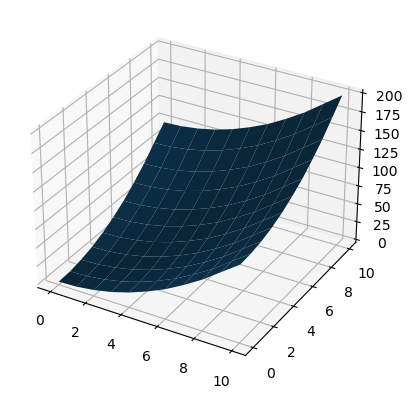

In [5]:
interp = RegularGridInterpolator([x_grid, y_grid], z_mat)
z_interp = interp(np.stack([x_new.flat, y_new.flat]).T).reshape(x_new.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_new, y_new, z_interp)
plt.show()

`HARK` already has a class called `LinearFast` which implements multivariate interpolation on a regular grid. We can also use this class to interpolate the function `squared_coords` at the points `x_new` and `y_new` and then plot the results.


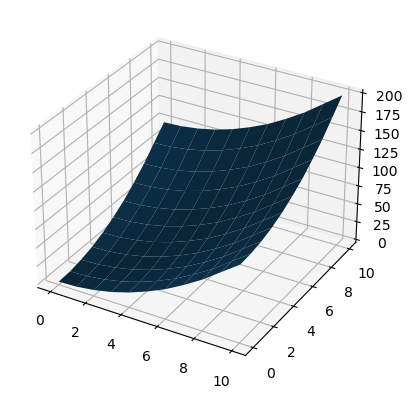

In [6]:
fast_interp = LinearFast(z_mat, [x_grid, y_grid])
z_fast_interp = fast_interp(x_new, y_new)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_new, y_new, z_fast_interp)
plt.show()

The benefit of `LinearFast` is that it is much faster than `RegularGridInterpolator`, even when the number of points is small. This is because `LinearFast` uses `interpolation.py` as a backend, which is just-in-time compiled with `numba`.


In [7]:
%%timeit
z_interp = interp(np.stack([x_new.flat, y_new.flat]).T).reshape(x_new.shape)

53.9 µs ± 2.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit
z_fast_interp = fast_interp(x_new, y_new)

7.4 µs ± 61 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


This notebook introduces a new class called `MultivariateInterp` which brings additional features and speed improvements. The key feature of `MultivariateInterp`, which we'll see later in this notebook, is its `backend` parameter, which can be set to `scipy`, `parallel`, or `gpu`. This allows the user to specify the backend device for the interpolation. Using `MultivariateInterp` mirrors the use of `LinearFast` and `RegularGridInterpolator` very closely.


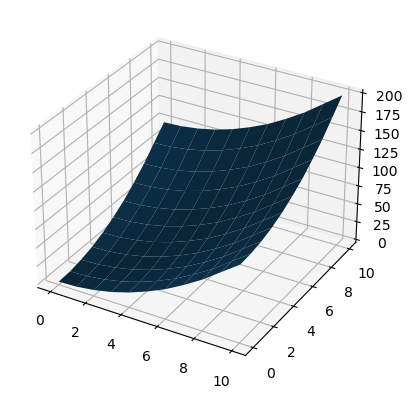

In [9]:
mult_interp = MultivariateInterp(z_mat, [x_grid, y_grid])
z_mult_interp = mult_interp(x_new, y_new)

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_new, y_new, z_mult_interp)
plt.show()

In [10]:
%%timeit
z_mult_interp = mult_interp(x_new, y_new)

18.4 µs ± 210 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


As we see above, `MultivariateInterp` is not at first glance faster than `LinearInterp`, and in some cases it can be significantly slower. However, the speed of `MultivariateInterp` is highly dependent on the number of points in the grid and the backend device. For example, for a large number of points, `MultivariateInterp` with `backend='numba'` can be shown to be significantly faster than `LinearFast`.


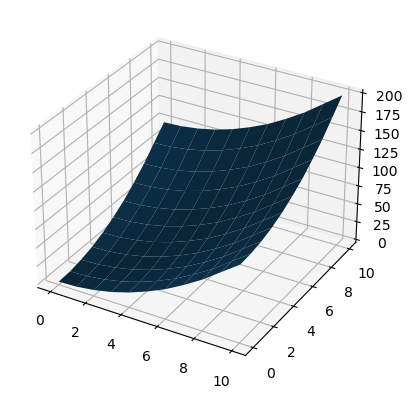

In [11]:
gpu_interp = MultivariateInterp(z_mat, [x_grid, y_grid], backend="cupy")
z_gpu_interp = gpu_interp(x_new, y_new).get()  # Get the result from GPU

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_new, y_new, z_gpu_interp)
plt.show()

We can test the results of `MultivariateInterp` and `LinearFast`, and we see that the results are almost identical.


In [12]:
np.allclose(z_fast_interp - z_gpu_interp, z_mult_interp - z_gpu_interp)

True

To experiment with `MultivariateInterp` and evaluate the conditions which make it faster than `LinearFast`, we can create a grid of data points and interpolation points and then time the interpolation on different backends.


In [13]:
n = 35
grid_max = 1000
grid = np.linspace(10, grid_max, n, dtype=int)
fast = np.empty((n, n))
scipy = np.empty_like(fast)
parallel = np.empty_like(fast)
gpu = np.empty_like(fast)
jax = np.empty_like(fast)

We will use the following function to time the execution of the interpolation.


In [14]:
def timeit(interp, x, y, min=1e-6):
    if not isinstance(interp, LinearFast):
        interp.compile()
    start = time()
    interp(x, y)
    return np.maximum(time() - start, min)

For different number of data points and approximation points, we can time the interpolation on different backends and use the results of `LinearFast` to normalize the results. This will give us a direct comparison of the speed of `MultivariateInterp` and `LinearFast`.


In [17]:
for i, j in product(range(n), repeat=2):
    data_grid = np.linspace(0, 10, grid[i])
    x_cross, y_cross = np.meshgrid(data_grid, data_grid, indexing="ij")
    z_cross = squared_coords(x_cross, y_cross)

    approx_grid = np.linspace(0, 10, grid[j])
    x_approx, y_approx = np.meshgrid(approx_grid, approx_grid, indexing="ij")

    fast_interp = LinearFast(z_cross, [data_grid, data_grid])
    time_norm = timeit(fast_interp, x_approx, y_approx)
    fast[i, j] = time_norm

    scipy_interp = MultivariateInterp(z_cross, [data_grid, data_grid], backend="scipy")
    scipy[i, j] = timeit(scipy_interp, x_approx, y_approx) / time_norm

    par_interp = MultivariateInterp(z_cross, [data_grid, data_grid], backend="numba")
    parallel[i, j] = timeit(par_interp, x_approx, y_approx) / time_norm

    gpu_interp = MultivariateInterp(z_cross, [data_grid, data_grid], backend="cupy")
    gpu[i, j] = timeit(gpu_interp, x_approx, y_approx) / time_norm

    jax_interp = MultivariateInterp(z_cross, [data_grid, data_grid], backend="jax")
    jax[i, j] = timeit(jax_interp, x_approx, y_approx) / time_norm

Text(0.5, 0, 'Approximation grid size (squared)')

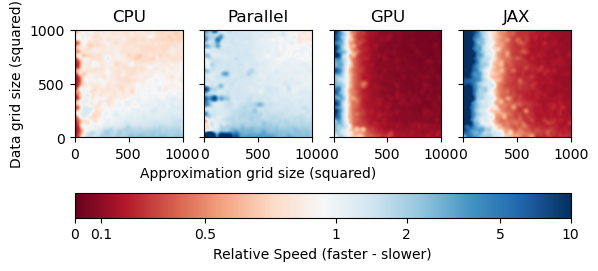

In [18]:
fig, ax = plt.subplots(1, 4, sharey=True)


ax[0].imshow(
    scipy,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[0].set_title("CPU")


ax[1].imshow(
    parallel,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[1].set_title("Parallel")

ax[2].imshow(
    gpu,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[2].set_title("GPU")

cbar = ax[3].imshow(
    jax,
    cmap="RdBu",
    origin="lower",
    norm=colors.SymLogNorm(1, vmin=0, vmax=10),
    interpolation="bicubic",
    extent=[0, grid_max, 0, grid_max],
)
ax[3].set_title("JAX")


cbar = fig.colorbar(
    cbar, ax=ax, label="Relative Speed (faster - slower)", location="bottom"
)
cbar.set_ticks([0, 0.1, 0.5, 1, 2, 5, 10])
cbar.set_ticklabels(["0", "0.1", "0.5", "1", "2", "5", "10"])
ax[0].set_ylabel("Data grid size (squared)")
ax[1].set_xlabel("Approximation grid size (squared)")

# uncomment to save figure
# fig.savefig(platform.system() + ".pdf")

As we can see from the results, `MultivariateInterp` is faster than `LinearFast` depending on the number of points and the backend device. A value of 1 represents the same speed as `LinearFast`, while a value less than 1 is faster (in red) and a value greater than 1 is slower (in blue).

[Windows]

For CPU, `MultivariateInterp` is (much) slower when the number of approximation points that need to be interpolated is very small, as seen by the deep blue areas. When the number of approximation points is moderate to large, however, `MultivariateInterp` is about as fast as `LinearFast`.

For Parallel, `MultivariateInterp` is slightly faster when the number of data points with known function value are greater than the number of approximation points that need to be interpolated. However, `backend='parallel'` still suffers from the high overhead when the number of approximation points is small.

For GPU, `MultivariateInterp` is much slower when the number of data points with known function value are small. This is because of the overhead of copying the data to the GPU. However, `backend='numba'` is significantly faster for any other case when the number of approximation points is large regardless of the number of data points.

[Linux]

For CPU and Parallel, `MultivariateInterp` is faster when the number of data points with known function value are greater than the number of approximation points that need to be interpolated. Surprisingly, `backend='parallel'` is not faster than `backend='scipy'` which was the expected result. This is probably because the `backend='scipy'` code uses highly specialized `numpy` and `scipy` code, so there may be few benefits to `just-in-time` compilation and parallelization.

For GPU, `MultivariateInterp` is slower when the number of approximation points that need to be interpolated is very small. This is because of the overhead of copying the data to the GPU. However, `backend='numba'` is significantly faster for any other case when the number of approximation points is large regardless of the number of data points.
